# 0-Libraries

In [220]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report,ConfusionMatrixDisplay, balanced_accuracy_score
#from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import Normalizer, StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler, QuantileTransformer, PowerTransformer
import tensorflow as tf
from tensorflow import keras
from keras import regularizers
from keras.optimizers import Adam
#from keras.backend import expand_dims
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.models import Sequential
from keras.constraints import MaxNorm
from keras.layers import Activation, Dense, Conv1D, Flatten, MaxPooling1D, Dropout, BatchNormalization, SpatialDropout1D

In [221]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'),
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

# 1- Load Data

In [222]:
s_aureus = pd.read_csv('s_aureus_driams_a_bin3_2000_20000Da.csv')
s_aureus.head()

,2000,2003,2006,2009,2012,2015,2018,2021,2024,2027,...,19991,19994,19997,code,species,Oxacillin,Clindamycin,Ceftriaxone,Ciprofloxacin,Fusidic acid
0,951.428571,826.125000,944.857143,898.428571,1007.714286,936.000000,828.571429,812.000000,782.714286,741.625000,...,35.5,20.5,27.342857,029f0abf-1664-424f-88cb-11c9c8af2b11,Staphylococcus aureus,0.0,0.0,0.0,0.0,1.0
1,784.714286,701.125000,681.571429,762.142857,737.571429,733.000000,735.857143,659.571429,802.714286,554.375000,...,30.0,40.5,34.695238,08149af1-10f5-4f02-81d8-3d46d66d4a7a,Staphylococcus aureus,0.0,0.0,0.0,0.0,0.0
2,50.875000,89.142857,56.142857,151.285714,132.714286,110.428571,47.285714,63.428571,100.375000,52.142857,...,2.5,30.5,11.288462,08fe3876-ecee-4ddc-9aa9-a84f605757f7,Staphylococcus aureus,0.0,0.0,0.0,0.0,0.0
3,843.285714,816.500000,734.428571,1027.142857,979.428571,875.571429,912.142857,714.428571,945.428571,886.500000,...,15.5,8.0,20.057143,0a9fdd4b-7180-47c0-849e-cb32d46da94c,Staphylococcus aureus,0.0,0.0,0.0,0.0,0.0
4,307.857143,295.000000,246.714286,181.571429,258.000000,318.714286,295.714286,300.857143,278.142857,256.125000,...,25.5,32.0,24.990476,0d82f4c4-473c-49d8-8c85-e3e36e96d047,Staphylococcus aureus,1.0,0.0,1.0,1.0,0.0


# Preprocessing Data

In [223]:
s_aureus_oxacillin = s_aureus.drop(columns=['code','species', 'Clindamycin', 'Ceftriaxone', 'Ciprofloxacin', 'Fusidic acid'])
s_aureus_oxacillin.dropna(axis=0, how="any", inplace=True)

In [224]:
s_aureus_ceftriaxone = s_aureus.drop(columns=['Oxacillin', 'Clindamycin', 'Ceftriaxone', 'Fusidic acid'])
#ceftriaxone.dropna(axis=0, how="any", inplace=True)
s_aureus_ceftriaxone.dropna(axis=0, how="any", inplace=True)
s_aureus_ceftriaxone.shape

(3757, 6003)

In [225]:
s_aureus_oxacillin.head()

,2000,2003,2006,2009,2012,2015,2018,2021,2024,2027,...,19973,19976,19979,19982,19985,19988,19991,19994,19997,Oxacillin
0,951.428571,826.125000,944.857143,898.428571,1007.714286,936.000000,828.571429,812.000000,782.714286,741.625000,...,14.333333,24.0,68.0,19.0,19.000000,50.0,35.5,20.5,27.342857,0.0
1,784.714286,701.125000,681.571429,762.142857,737.571429,733.000000,735.857143,659.571429,802.714286,554.375000,...,15.666667,39.0,19.5,42.0,69.666667,31.0,30.0,40.5,34.695238,0.0
2,50.875000,89.142857,56.142857,151.285714,132.714286,110.428571,47.285714,63.428571,100.375000,52.142857,...,20.666667,17.0,2.0,18.0,18.000000,11.5,2.5,30.5,11.288462,0.0
3,843.285714,816.500000,734.428571,1027.142857,979.428571,875.571429,912.142857,714.428571,945.428571,886.500000,...,22.333333,33.0,29.0,14.5,21.666667,24.5,15.5,8.0,20.057143,0.0
4,307.857143,295.000000,246.714286,181.571429,258.000000,318.714286,295.714286,300.857143,278.142857,256.125000,...,26.666667,25.5,18.0,53.5,23.000000,24.5,25.5,32.0,24.990476,1.0


In [226]:
X = s_aureus_oxacillin.iloc[:, 0:6000].values  # variables independientes (espectros de masa)
y = s_aureus_oxacillin.iloc[:, 6000].values    # variable dependientes (resistencia a ciprofloxacin)
X = np.asarray(X).astype(np.float32)
y = np.asarray(y).astype(np.float32)

In [227]:
s_aureus_oxacillin

,2000,2003,2006,2009,2012,2015,2018,2021,2024,2027,...,19973,19976,19979,19982,19985,19988,19991,19994,19997,Oxacillin
0,951.428571,826.125000,944.857143,898.428571,1007.714286,936.000000,828.571429,812.000000,782.714286,741.625000,...,14.333333,24.0,68.0,19.0,19.000000,50.0,35.5,20.500000,27.342857,0.0
1,784.714286,701.125000,681.571429,762.142857,737.571429,733.000000,735.857143,659.571429,802.714286,554.375000,...,15.666667,39.0,19.5,42.0,69.666667,31.0,30.0,40.500000,34.695238,0.0
2,50.875000,89.142857,56.142857,151.285714,132.714286,110.428571,47.285714,63.428571,100.375000,52.142857,...,20.666667,17.0,2.0,18.0,18.000000,11.5,2.5,30.500000,11.288462,0.0
3,843.285714,816.500000,734.428571,1027.142857,979.428571,875.571429,912.142857,714.428571,945.428571,886.500000,...,22.333333,33.0,29.0,14.5,21.666667,24.5,15.5,8.000000,20.057143,0.0
4,307.857143,295.000000,246.714286,181.571429,258.000000,318.714286,295.714286,300.857143,278.142857,256.125000,...,26.666667,25.5,18.0,53.5,23.000000,24.5,25.5,32.000000,24.990476,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3786,288.000000,330.285714,296.142857,265.142857,310.750000,287.000000,345.000000,260.000000,198.714286,257.285714,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.004038,0.0
3787,1286.142857,989.714286,938.285714,901.428571,872.000000,1001.000000,1061.571429,890.857143,813.857143,961.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.053908,0.0
3788,986.857143,977.285714,892.285714,986.714286,1045.875000,986.857143,963.571429,968.571429,960.857143,969.714286,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.039084,0.0
3789,141.857143,197.428571,148.142857,114.000000,125.857143,158.750000,176.571429,148.285714,149.714286,151.714286,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.012113,0.0


In [228]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0, stratify=y)

In [243]:
print(pd.Series(y_train).value_counts())

0.0    2451
1.0     581
Name: count, dtype: int64


## Enfoque en clase minoritaria

In [231]:
minority_class = s_aureus_oxacillin[s_aureus_oxacillin['Oxacillin'] == 1].drop(columns=['Oxacillin'])


In [232]:
minority_class

,2000,2003,2006,2009,2012,2015,2018,2021,2024,2027,...,19970,19973,19976,19979,19982,19985,19988,19991,19994,19997
4,307.857143,295.000000,246.714286,181.571429,258.000000,318.714286,295.714286,300.857143,278.142857,256.125000,...,16.5,26.666667,25.5,18.0,53.5,23.000000,24.5,25.5,32.0,24.990476
10,233.142857,282.500000,276.142857,216.428571,198.000000,255.000000,225.571429,228.571429,190.142857,241.375000,...,14.0,14.333333,18.0,25.5,4.5,32.333333,21.5,18.0,31.5,16.295238
15,539.571429,631.250000,579.000000,482.857143,673.571429,644.714286,527.714286,544.142857,514.428571,525.000000,...,60.0,16.666667,26.5,29.5,26.0,7.333333,18.0,17.0,30.0,23.180952
20,808.571429,957.625000,807.285714,656.857143,747.714286,801.571429,805.857143,727.857143,712.571429,675.625000,...,25.5,27.333333,31.0,59.5,16.5,28.333333,81.0,34.5,36.5,30.161905
24,694.285714,700.750000,525.571429,691.285714,687.857143,693.714286,596.142857,614.714286,453.571429,530.000000,...,8.5,16.000000,24.5,24.5,25.5,3.333333,5.0,13.5,23.5,20.771429
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3758,348.000000,417.285714,323.142857,357.142857,359.428571,365.571429,360.875000,340.285714,331.857143,334.142857,...,21.5,26.666667,21.0,22.0,20.5,30.666667,14.5,22.5,26.0,24.800000
3765,440.600000,459.857143,337.714286,331.857143,375.571429,343.750000,395.857143,324.142857,313.571429,336.571429,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
3766,554.714286,591.142857,518.625000,518.714286,457.571429,511.571429,492.428571,540.571429,544.000000,574.375000,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.024259
3769,206.571429,192.571429,192.571429,226.000000,194.125000,222.428571,252.714286,216.428571,190.857143,189.571429,...,3.5,1.666667,5.5,4.0,4.0,1.000000,4.5,2.0,1.5,2.000000


In [233]:
etiquetas = s_aureus_oxacillin[s_aureus_oxacillin['Oxacillin'] == 1].iloc[:, 6000].values

## Diffusion model


In [234]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [235]:
torch.manual_seed(42)
np.random.seed(42)

In [236]:
# Preprocesamiento
scaler = StandardScaler()
scaled_data = scaler.fit_transform(minority_class.values)

In [237]:
# Modelo de Difusión
class DiffusionModel(nn.Module):
    def __init__(self, input_dim):
        super(DiffusionModel, self).__init__()
        self.model = nn.Sequential( 
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Dropout(p=0.2),  # Regularización Dropout
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(p=0.2),  # Regularización Dropout
            nn.Linear(128, input_dim)
        )


    def forward(self, x):
        return self.model(x)


In [238]:
# Función de ruido (Scheduler)
def add_noise(data, timesteps, noise_scale=1.0):
    noise = np.random.normal(0, noise_scale, data.shape) * np.sqrt(timesteps / 100)
    noisy_data = data + noise
    return noisy_data, noise


In [239]:
# Configuración del modelo
input_dim = scaled_data.shape[1]
model = DiffusionModel(input_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.SmoothL1Loss()  # O Huber Loss


In [240]:
scaled_data.shape[1]

6000

In [241]:
# Scheduler de tasa de aprendizaje
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.9)


In [245]:
# Entrenamiento
scaled_data_tensor = torch.tensor(scaled_data, dtype=torch.float32)
epochs = 1000
losses = []  # Para guardar la pérdida por época

for epoch in range(epochs):
    timesteps = np.random.randint(1, 100)
    noisy_data, noise = add_noise(scaled_data, timesteps)
    noisy_data_tensor = torch.tensor(noisy_data, dtype=torch.float32)
    noise_tensor = torch.tensor(noise, dtype=torch.float32)

    optimizer.zero_grad()
    predicted_noise = model(noisy_data_tensor)
    loss = loss_fn(predicted_noise, noise_tensor)
    loss.backward()
    optimizer.step()
    scheduler.step()  # Actualiza la tasa de aprendizaje

    losses.append(loss.item())

    if epoch % 100 == 0:
        print(f"Epoch {epoch}/{epochs} - Loss: {loss.item()}")


Epoch 0/1000 - Loss: 0.38587987422943115
Epoch 100/1000 - Loss: 0.36832061409950256
Epoch 200/1000 - Loss: 0.32766079902648926
Epoch 300/1000 - Loss: 0.4007006585597992
Epoch 400/1000 - Loss: 0.34306955337524414
Epoch 500/1000 - Loss: 0.12827734649181366
Epoch 600/1000 - Loss: 0.4145435392856598
Epoch 700/1000 - Loss: 0.39648646116256714
Epoch 800/1000 - Loss: 0.07489648461341858
Epoch 900/1000 - Loss: 0.34258225560188293


In [246]:
# Generación de Datos Sintéticos
def generate_synthetic_data(model, num_samples, input_dim):
    model.eval()
    with torch.no_grad():
        synthetic_data = np.random.normal(0, 1, (num_samples, input_dim))
        for t in range(100, 0, -1):  # Reverse diffusion
            synthetic_data = synthetic_data - model(torch.tensor(synthetic_data, dtype=torch.float32)).numpy() * (t / 100)
        return synthetic_data

In [247]:
print(pd.Series(y_train).value_counts())

0.0    2451
1.0     581
Name: count, dtype: int64


In [249]:

synthetic_data = generate_synthetic_data(model, 1000-pd.Series(y_train).value_counts()[1], input_dim)
synthetic_data_rescaled = scaler.inverse_transform(synthetic_data)


In [254]:

# Cambiar el tipo de datos a float32
synthetic_samples_numpy = synthetic_data_rescaled.astype(np.float32)

# Mostrar las muestras generadas
synthetic_samples_numpy

array([[ 9.0498560e+02,  5.0457233e+01,  8.5809583e+02, ...,
         3.0732567e+01,  3.9293800e+01,  2.7740623e+01],
       [-4.9939087e+03,  5.8327124e+03,  5.5675264e+03, ...,
        -2.9014702e+01,  1.9111019e+01,  6.6651131e+01],
       [ 4.7997079e+02, -5.7491162e+03,  2.0721169e+03, ...,
        -2.7736969e+01,  1.5896610e+01,  3.6019653e+01],
       ...,
       [ 1.1805342e+03,  4.0286350e+01,  6.4016956e+02, ...,
        -3.0936909e-01, -1.5711686e+01,  4.6499390e+01],
       [-6.6370837e+02,  3.8957070e+03,  2.7459722e+03, ...,
         2.3742726e+00,  4.2396793e+01, -1.7404764e+01],
       [ 2.4455303e+03,  1.8413577e+03,  1.9530249e+02, ...,
         2.0874767e+01,  4.0500908e+01, -4.4321804e+00]], dtype=float32)

In [261]:
print(pd.Series(y_train_balanced).value_counts())

0.0    2451
1.0    1000
Name: count, dtype: int64


In [258]:
array_ones = np.ones(1000-pd.Series(y_train).value_counts()[1])
array_ones = np.asarray(array_ones).astype(np.float32)

In [259]:
y_train_balanced = np.concatenate((y_train, array_ones))


In [251]:
X_train_balanced = np.concatenate((X_train,synthetic_samples_numpy))

#X_resampled, y_resampled = smote.fit_resample(X_train, y_train)


In [262]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_balanced, y_train_balanced)

In [263]:
print(pd.Series(y_resampled).value_counts())

1.0    2451
0.0    2451
Name: count, dtype: int64


In [ ]:
from imblearn.over_sampling import SMOTE

# Número de muestras adicionales que deseas
nuevas_muestras = 1000-pd.Series(y_train).value_counts()[1]

# Calcular el número total deseado para la clase minoritaria
n_clase_minoritaria_actual = sum(y_train == 1)  # Asumiendo que '1' es la clase minoritaria
n_total_deseado = n_clase_minoritaria_actual + nuevas_muestras

# Calcular el sampling_strategy
sampling_strategy = {0: sum(y_train == 0), 1: n_total_deseado}  # Ajustar según tus clases

# Crear el SMOTE con la estrategia personalizada
smote = SMOTE(sampling_strategy=sampling_strategy, random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train) 

In [197]:
pd.Series(y_resampled).value_counts()[0]-pd.Series(y_resampled).value_counts()[1]

1451

In [ ]:
synthetic_data

array([[-1.40613362,  0.60651276, -0.75093074, ..., -0.32115189,
         0.65046253, -0.34425375],
       [ 0.09830046, -1.03430403, -0.06209162, ...,  0.09037326,
        -1.37007885,  1.67466633],
       [ 0.47762   , -0.08037955,  0.57791481, ..., -0.4425656 ,
         0.1119489 , -1.59218036],
       ...,
       [-0.18995026, -0.66049683,  0.01077942, ..., -1.99385818,
        -0.25115836,  0.65849017],
       [-0.81897336, -0.55182063, -1.23450974, ...,  1.05769053,
        -1.15664356,  0.46635172],
       [ 1.06497965,  0.2612687 ,  0.62359093, ..., -0.95488923,
         0.83089286,  1.22937258]])

In [202]:
array_ones = np.ones(pd.Series(y_train).value_counts()[0]-pd.Series(y_train).value_counts()[1])
array_ones = np.asarray(array_ones).astype(np.float32)

In [203]:
y_train_balanced = np.concatenate((y_resampled, array_ones))


In [ ]:
synthetic_data_rescaled.shape

(1451, 6000)

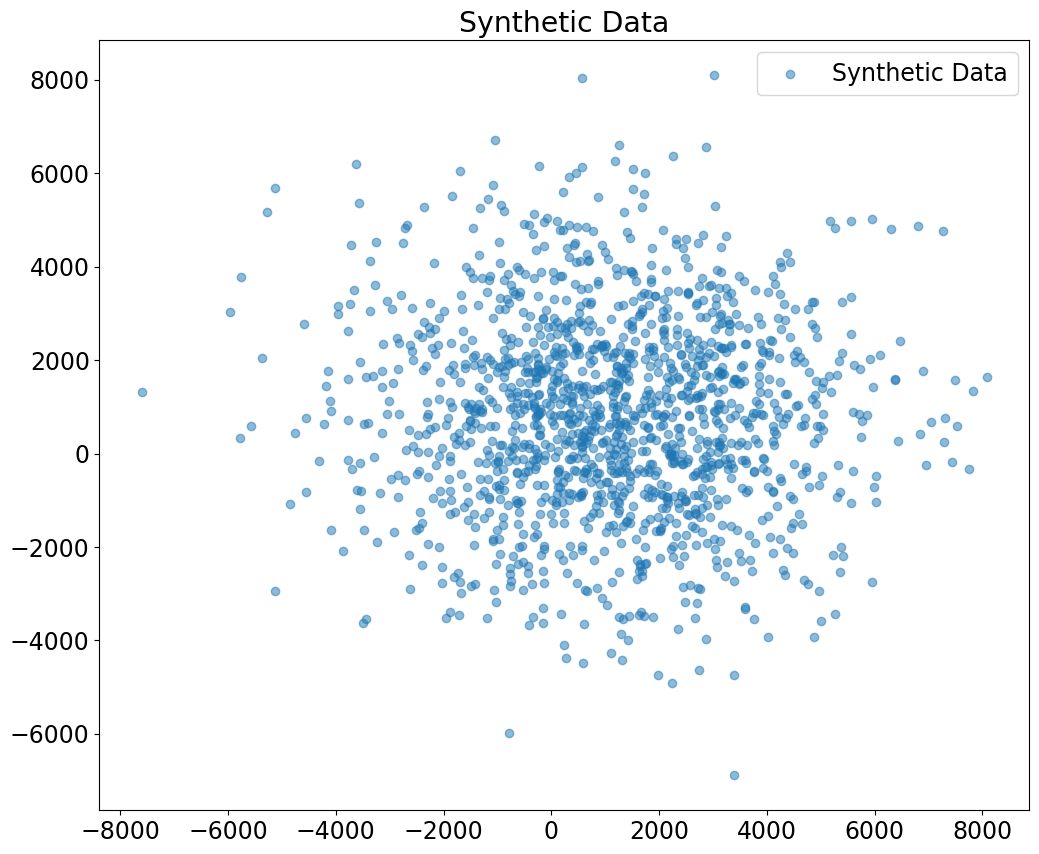

In [ ]:
# Visualización
#plt.scatter(minority_class['feature1'], minority_class['feature2'], alpha=0.5, label='Original Data')
plt.scatter(synthetic_data_rescaled[:, 0], synthetic_data_rescaled[:, 1], alpha=0.5, label='Synthetic Data')
plt.legend()
plt.title('Synthetic Data')
plt.show()

## Termino oversampling

In [206]:
len(X)

3790

In [ ]:
len(X_train)

3032

In [ ]:
len(y_train)


3032

In [209]:
#X_resampled, y_resampled = smote.fit_resample(X_train, y_train)


In [264]:
scaler=Normalizer(norm='max')
sc_X = scaler
X_train = sc_X.fit_transform(X_resampled)
X_test = sc_X.transform(X_test)

In [265]:
sample_size = X_train.shape[0] # numero de muestras en el set de datos
time_steps  = X_train.shape[1] # numero de atributos en el set de datos
input_dimension = 1            #

X_train_reshaped = X_train.reshape(sample_size,time_steps,input_dimension)
X_test_reshaped = X_test.reshape(X_test.shape[0],X_test.shape[1],1)

In [266]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=0.000001)
early_st = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)

n_timesteps = X_train_reshaped.shape[1] #
n_features  = X_train_reshaped.shape[2] #

In [267]:
print(pd.Series(y_train_balanced).value_counts())


0.0    2451
1.0    1000
Name: count, dtype: int64


# Create and fit DeepAMR model

In [268]:
model = Sequential(name="Modelo_s_aureus_ciprofloxacin")
init_mode = 'normal'
model.add(Conv1D(filters=(64), kernel_size=(17), input_shape = (n_timesteps,n_features), name='Conv_1'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=2, name="MaxPooling1D_1"))

model.add(Conv1D(filters=(128), kernel_size=(9),kernel_initializer=init_mode, kernel_regularizer=regularizers.l2(0.0001),  name='Conv_2'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=2, name="MaxPooling1D_2"))

model.add(Conv1D(filters=(256), kernel_size=(5),kernel_initializer=init_mode,kernel_regularizer=regularizers.l2(0.0001),   name='Conv_3'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=2, name="MaxPooling1D_3"))

model.add(Conv1D(filters=(256), kernel_size=(5),kernel_initializer=init_mode, kernel_regularizer=regularizers.l2(0.0001),   name='Conv_4'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=2, name="MaxPooling1D_4"))

model.add(Flatten())
model.add(Dropout(0.65))
model.add(Dense(256, activation='relu',kernel_initializer=init_mode, kernel_regularizer=regularizers.l2(0.0001), name="fully_connected_0"))
model.add(Dense(64, activation='relu',kernel_initializer=init_mode, kernel_regularizer=regularizers.l2(0.0001), name="fully_connected_1"))
model.add(Dense(64, activation='relu',kernel_initializer=init_mode, kernel_regularizer=regularizers.l2(0.0001),  name="fully_connected_2"))
model.add(Dense(n_features, activation='sigmoid', name="OUT_Layer"))

model.compile(optimizer = Adam(learning_rate=0.0001), loss = 'binary_crossentropy',  metrics=METRICS)
model.summary()

Model: "Modelo_s_aureus_ciprofloxacin"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv_1 (Conv1D)             (None, 5984, 64)          1152      
                                                                 
 batch_normalization_20 (Bat  (None, 5984, 64)         256       
 chNormalization)                                                
                                                                 
 activation_20 (Activation)  (None, 5984, 64)          0         
                                                                 
 MaxPooling1D_1 (MaxPooling1  (None, 2992, 64)         0         
 D)                                                              
                                                                 
 Conv_2 (Conv1D)             (None, 2984, 128)         73856     
                                                                 
 batch_normalization_21 (Bat  (None, 

In [269]:
history = model.fit(X_train_reshaped, y_resampled, epochs=100, batch_size=10, verbose=1, validation_split=0.1, callbacks=[reduce_lr,early_st])

Epoch 1/100
442/442 [==============================] - 12s 23ms/step - loss: 6.1452 - tp: 1099.0000 - fp: 445.0000 - tn: 2006.0000 - fn: 861.0000 - accuracy: 0.7039 - precision: 0.7118 - recall: 0.5607 - auc: 0.7562 - prc: 0.7693 - val_loss: 5.8247 - val_tp: 86.0000 - val_fp: 0.0000e+00 - val_tn: 0.0000e+00 - val_fn: 405.0000 - val_accuracy: 0.1752 - val_precision: 1.0000 - val_recall: 0.1752 - val_auc: 0.0000e+00 - val_prc: 1.0000 - lr: 1.0000e-04
Epoch 2/100
442/442 [==============================] - 10s 22ms/step - loss: 5.2236 - tp: 1295.0000 - fp: 343.0000 - tn: 2108.0000 - fn: 665.0000 - accuracy: 0.7715 - precision: 0.7906 - recall: 0.6607 - auc: 0.8474 - prc: 0.8511 - val_loss: 4.8710 - val_tp: 369.0000 - val_fp: 0.0000e+00 - val_tn: 0.0000e+00 - val_fn: 122.0000 - val_accuracy: 0.7515 - val_precision: 1.0000 - val_recall: 0.7515 - val_auc: 0.0000e+00 - val_prc: 1.0000 - lr: 1.0000e-04
Epoch 3/100
442/442 [==============================] - 10s 22ms/step - loss: 4.6172 - tp: 140

# Evaluate the model

In [ ]:
y_pred  = model.predict(X_test_reshaped)
y_pred = (y_pred>0.5)
cm = confusion_matrix(y_test, y_pred)
print(cm)

24/24 [==============================] - 0s 8ms/step
[[517  96]
 [ 31 114]]


In [ ]:
print("balanced acuracy:", balanced_accuracy_score(y_test, y_pred))

balanced acuracy: 0.8148000225009844


In [ ]:
target_names=["0","1"]
print(classification_report(y_test, y_pred, target_names=target_names))

train_predictions_baseline = model.predict(X_train_reshaped, batch_size=10)
test_predictions_baseline = model.predict(X_test_reshaped, batch_size=10)

baseline_results = model.evaluate(X_test_reshaped, y_test, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

              precision    recall  f1-score   support

           0       0.94      0.84      0.89       613
           1       0.54      0.79      0.64       145

    accuracy                           0.83       758
   macro avg       0.74      0.81      0.77       758
weighted avg       0.87      0.83      0.84       758

76/76 [==============================] - 0s 4ms/step
loss :  1.1462087631225586
tp :  114.0
fp :  96.0
tn :  517.0
fn :  31.0
accuracy :  0.8324538469314575
precision :  0.5428571701049805
recall :  0.7862069010734558
auc :  0.8889914155006409
prc :  0.7744895219802856



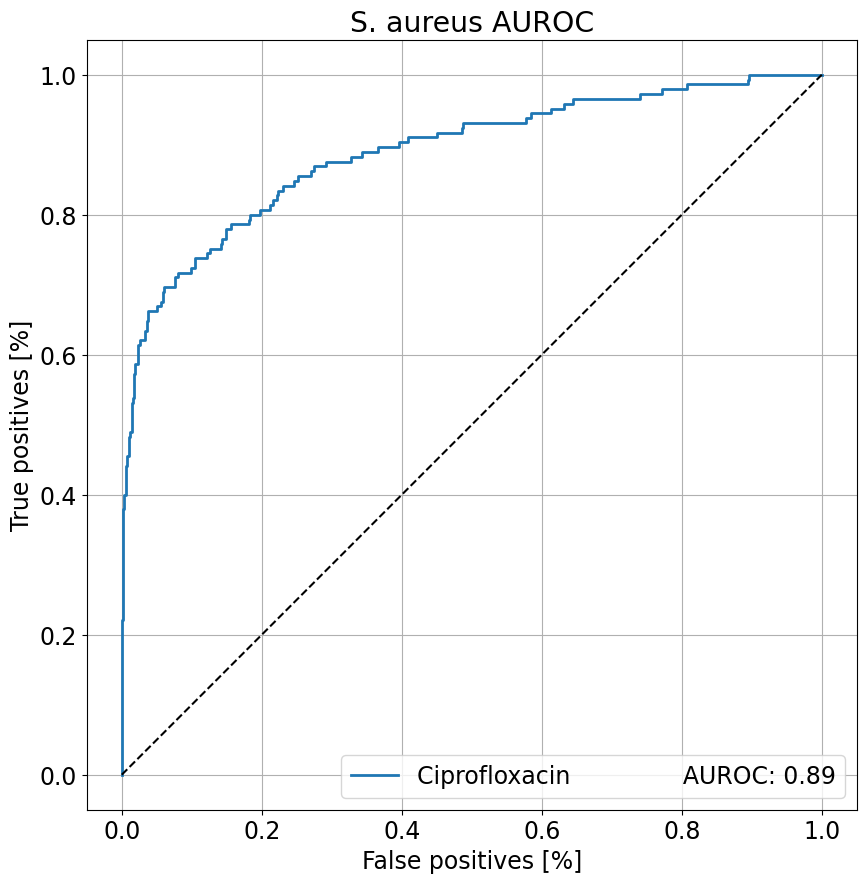

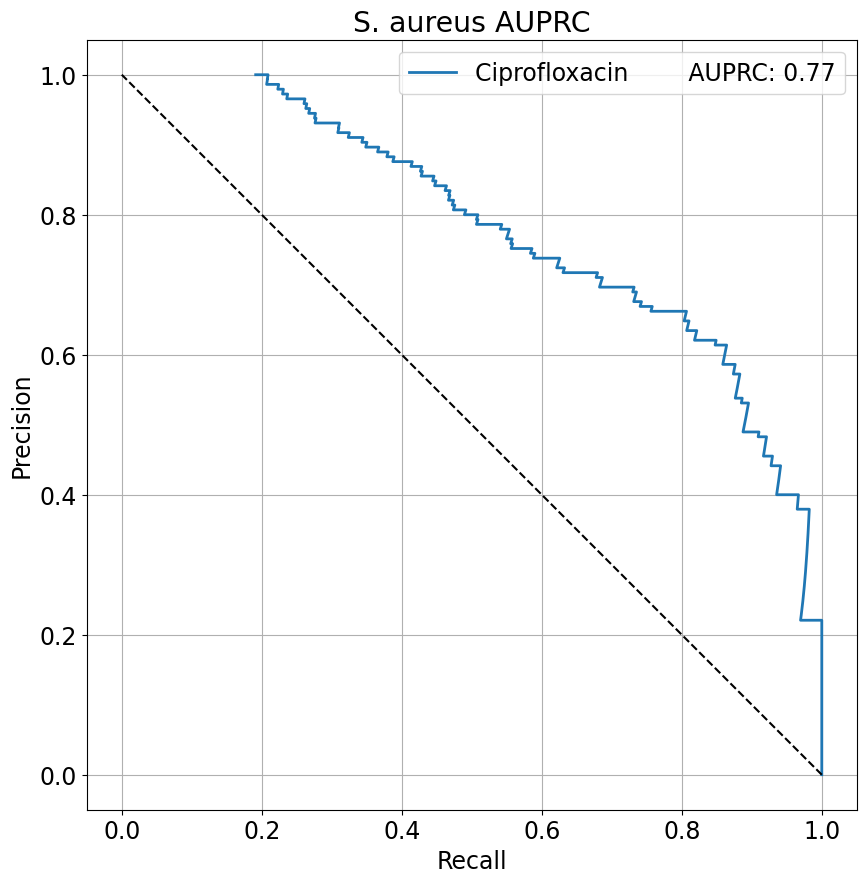

In [ ]:
plt.rcParams['figure.figsize'] = (12, 10)
plt.rcParams.update({'font.size': 17})
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

  plt.plot(fp, tp, label=name, linewidth=2, **kwargs)
  plt.plot([0, 1], [0, 1], 'k--')
  plt.title('E. coli CNN')
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.title('S. aureus AUROC')

  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')
plot_roc("Ciprofloxacin               AUROC: %0.2f" % baseline_results[8], y_test, test_predictions_baseline, color=colors[0])

plt.legend(loc='lower right')
plt.savefig('s_aureus_auroc.png', bbox_inches='tight')
plt.show()

def plot_prc(name, labels, predictions, **kwargs):
    precision, recall, _ = sklearn.metrics.precision_recall_curve(labels, predictions)

    plt.plot(precision, recall, label=name, linewidth=2, **kwargs)
    plt.title('S. aureus AUPRC')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.plot([1, 0], [0, 1], 'k--')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

plot_prc("Ciprofloxacin        AUPRC: %0.2f" % baseline_results[9], y_test, test_predictions_baseline, color=colors[0])

plt.legend(loc='upper right')
plt.savefig('s_aureus_auprc.png', bbox_inches='tight')
plt.show()